In [1]:
import pandas as pd
import json
import collections
import scipy.io
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import geopy.distance
import math

In [2]:
bus = scipy.io.loadmat('MATPOWER/bus.mat')['bus']
power_demand = bus[:, 2]
df = pd.read_csv("GIS/CATS_gens.csv")
df = df[df['Pmax'] != 0.0].to_numpy()
#df = df.drop_duplicates(subset=['PlantCode','GenID']).to_numpy()
bus_loc = pd.read_csv("GIS/CATS_buses.csv").to_numpy()[:, [4,5]]
gen_loc = df[:, -2:]

In [3]:
gen_by_fuel = collections.defaultdict(float)
for row in df:
    gen_by_fuel[row[3]] += row[5]
gen_by_fuel

defaultdict(float,
            {'Conventional Hydroelectric': 7922.999999999999,
             'Petroleum Liquids': 369.09999999999997,
             'Natural Gas Fired Combustion Turbine': 10893.39999999999,
             'Natural Gas Internal Combustion Engine': 325.5999999999998,
             'Natural Gas Fired Combined Cycle': 19649.300000000007,
             'Natural Gas Steam Turbine': 4744.799999999999,
             'Landfill Gas': 278.6,
             'Batteries': 229.50000000000003,
             'Hydroelectric Pumped Storage': 759.1,
             'Geothermal': 1095.2,
             'Nuclear': 2323.0,
             'Onshore Wind Turbine': 5303.000000000001,
             'Other Waste Biomass': 168.5999999999999,
             'Wood/Wood Waste Biomass': 504.8,
             'Solar Photovoltaic': 11639.398672710053,
             'Solar Thermal without Energy Storage': 1156.00132935,
             'All Other': 113.69999999999999,
             'Conventional Steam Coal': 55.0,
             'O

([<matplotlib.patches.Wedge at 0x1e88a4fb150>,
 [Text(0.008822083223560487, 1.099964622543651, 'Natural Gas'),
  Text(-0.9416798562968521, -0.5685411579162409, 'Solar'),
  Text(-0.3964148472226188, -1.0260873592932855, 'Nuclear'),
  Text(-0.2897713804616283, -1.06114680749902, 'Coal'),
  Text(0.11916644057966173, -1.093526112829307, 'Hydro'),
  Text(0.5372036601415324, -0.9599021968568158, 'Biomass'),
  Text(0.5815088941664028, -0.9337276937123411, 'Other'),
  Text(0.6408366730904249, -0.8940516531064613, 'Geothermal'),
  Text(0.8593296373111293, -0.6866968577463589, 'Wind'),
  Text(1.07269934041913, -0.24354901983864313, 'Import')],
 [Text(0.004812045394669356, 0.5999807032056278, '49.7%'),
  Text(-0.5136435579801011, -0.3101133588634041, '17.8%'),
  Text(-0.21622628030324662, -0.5596840141599738, '3.2%'),
  Text(-0.1580571166154336, -0.57880734954492, '0.1%'),
  Text(0.06499987667981548, -0.5964687888159855, '11.9%'),
  Text(0.29302017825901766, -0.523583016467354, '0.9%'),
  Text(0.

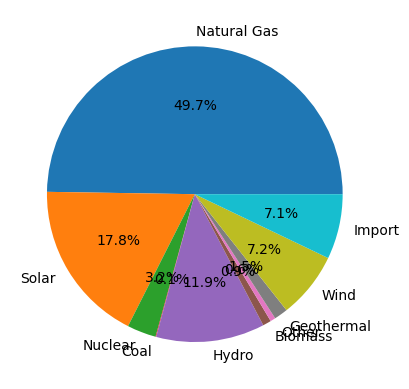

In [4]:
y = [0]*10
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k or 'Other Gases' in k or 'Petroleum' in k or 'Lanfill' in k:
        y[0] += v
    elif 'Solar' in k or 'Batteries' in k:
        y[1] += v
    elif 'Nuclear' in k:
        y[2] += v
    elif 'Coal' in k:
        y[3] += v
    elif 'Hydro' in k:
        y[4] += v
    elif 'Biomass' in k:
        y[5] += v
    elif 'Geothermal' in k:
        y[7] += v
    elif 'Wind' in k:
        y[8] += v
    elif 'IMPORT' in k:
        y[9] += v
    else:
        y[6] += v
gen_by_fuel
x = ['Natural Gas', 'Solar','Nuclear','Coal','Hydro','Biomass','Other','Geothermal','Wind','Import']
fig, ax = plt.subplots()
ax.pie(y, labels=x,autopct='%1.1f%%')

In [5]:
# https://www.eia.gov/electricity/data/emissions/
gen_emission = pd.read_excel("data/emissions2019.xlsx")
gen_emission = gen_emission[gen_emission['Generation (kWh)'] > 0]
gen_emission = gen_emission[gen_emission['State'] == 'CA']
gen_emission = gen_emission[['Plant Code','Fuel Code','Aggregated Fuel Group','Generation (kWh)','Metric Tonnes of CO2 Emissions','carbon emission rate']]
gen_emission.groupby(['Aggregated Fuel Group'])['carbon emission rate'].median()
# get carbon emssion rate of each fuel type (tons/mWh)

Aggregated Fuel Group
COAL    4.668269
GAS     0.585267
GEO     0.026307
MSW     0.834394
PET     1.120323
Name: carbon emission rate, dtype: float64

In [6]:
gen_emission.groupby(['Fuel Code'])['carbon emission rate'].median()

Fuel Code
BIT    4.642909
DFO    1.191675
GEO    0.026307
JF     1.180994
MSW    0.834394
NG     0.585267
PG     1.083609
RC     4.693628
WO     0.534195
Name: carbon emission rate, dtype: float64

In [7]:
type_to_emission = collections.defaultdict(float)
type_to_emission['Conventional Hydroelectric'] = 0.001
type_to_emission['Hydroelectric Pumped Storage'] = 0.001
type_to_emission['Petroleum Liquids'] = 1.162800
type_to_emission['Natural Gas Internal Combustion Engine'] = 0.646560
type_to_emission['Natural Gas Fired Combined Cycle'] = 0.646560
type_to_emission['Natural Gas Steam Turbine'] = 0.646560
type_to_emission['Natural Gas Fired Combustion Turbine'] = 0.646560
type_to_emission['Nuclear'] = 0.001
type_to_emission['Geothermal'] = 0.026307
type_to_emission['Onshore Wind Turbine'] = 0.001
type_to_emission['Other Waste Biomass'] = 0.01
type_to_emission['Wood/Wood Waste Biomass'] = 0.01
type_to_emission['Landfill Gas'] = 0.646560
type_to_emission['Solar Photovoltaic'] = 0.001
type_to_emission['Solar Thermal without Energy Storage'] = 0.001
type_to_emission['Conventional Steam Coal'] = 4.668269
type_to_emission['Other Gases'] = 0.646560
type_to_emission['Batteries'] = 0.001
type_to_emission['Petroleum Coke'] = 1.162800
type_to_emission['Municipal Solid Waste'] = 0.834394
type_to_emission['Other Natural Gas'] = 0.604
type_to_emission['All Other'] = 0.1
type_to_emission['IMPORT'] = 0.5
#type_to_emission['Synchronous Condenser'] = 884

In [8]:
# https://www.epa.gov/egrid
emission_power_plant = pd.read_excel("data/emission_egrid.xlsx")
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant["plant_emission_rate"] = emission_power_plant["Plant annual CO2 emissions"]/emission_power_plant["Plant annual net generation"]

In [9]:
emission_power_plant.groupby(['Plant primary coal/oil/gas/ other fossil fuel category'])['plant_emission_rate'].mean()

Plant primary coal/oil/gas/ other fossil fuel category
BIOMASS       0.031964
COAL          0.574314
GAS           0.392918
GEOTHERMAL    0.064474
HYDRO         0.000000
NUCLEAR       0.000000
OFSL          0.420986
OIL           1.114133
OTHF          0.302718
SOLAR         0.000501
WIND          0.000000
Name: plant_emission_rate, dtype: float64

In [10]:
# egrid_2019
# https://www.epa.gov/egrid
# we have percent mixure of power generation by fuel types. We have carbon emission rate of each generator. We can get the carbon emission rate of the each fuel type.
emission_power_plant = pd.read_excel("data/Book1.xlsx")
pd.set_option('display.max_columns', None)
emission_power_plant = emission_power_plant[emission_power_plant['Plant annual net generation (MWh)'] > 0]
emission_power_plant = emission_power_plant[emission_power_plant['Plant state abbreviation'] == 'CA']
emission_power_plant['Plant annual CO2 equivalent total output emission rate (metric tons/MWh)'] = emission_power_plant['Plant annual CO2 equivalent total output emission rate (lb/MWh)']/2204.62
emission_power_plant.head(5)

Plant state abbreviation  DOE/EIA ORIS plant or facility code  Utility ID  \
474                       CA                                57310       57320   
475                       CA                                58918       61315   
476                       CA                                58920       61315   
477                       CA                                58919       61315   
478                       CA                                57871       11208   

     Plant FIPS county code  Plant latitude  Plant longitude  \
474                    37.0       33.794283      -118.241405   
475                    19.0       36.670000      -119.415833   
476                    47.0       37.352222      -120.506944   
477                     7.0       39.291667      -121.669722   
478                    37.0       34.026944      -118.224167   

    Plant primary fuel Plant primary coal/oil/gas/ other fossil fuel category  \
474                SUN                                              SOLAR       
475                SUN                                              SOLAR       
476                SUN                                              SOLAR       
477                SUN                                              SOLAR       
478                SUN                                              SOLAR       

     Plant annual net generation (MWh)  \
474                             1781.0   
475                             1535.0   
476                             2656.0   
477                             2410.0   
478                             1252.0   

     Plant annual CO2 equivalent emissions (tons)  \
474                                           0.0   
475                                           0.0   
476                                           0.0   
477                                           0.0   
478                                           0.0   

     Plant annual CO2 equivalent total output emission rate (lb/MWh)  \
474                                                0.0                 
475                                                0.0                 
476                                                0.0                 
477                                                0.0                 
478                                                0.0                 

     Plant coal generation percent (resource mix)  \
474                                           0.0   
475                                           0.0   
476                                           0.0   
477                                           0.0   
478                                           0.0   

     Plant oil generation percent (resource mix)  \
474                                          0.0   
475                                          0.0   
476                                          0.0   
477                                          0.0   
478                                          0.0   

     Plant gas generation percent (resource mix)  \
474                                          0.0   
475                                          0.0   
476                                          0.0   
477                                          0.0   
478                                          0.0   

     Plant nuclear generation percent (resource mix)  \
474                                              0.0   
475                                              0.0   
476                                              0.0   
477                                              0.0   
478                                              0.0   

     Plant hydro generation percent (resource mix)  \
474                                            0.0   
475                                            0.0   
476                                            0.0   
477                                            0.0   
478                                            0.0   

     Plant biomass generation per

In [11]:
# Use least square. Percent fuel type of each gen * carbon emission of each fuel type = carbon emission of each gen
A = emission_power_plant.to_numpy()[:, 11:-1]
b = emission_power_plant.to_numpy()[:, -1]
x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type
dict_carb = collections.defaultdict(float)
dict_carb["Coal"] = x[0]
dict_carb["Oil"] = x[1]
dict_carb["Gas"] = x[2]
dict_carb["Nuclear"] = x[3]
dict_carb["Hydro"] = x[4]
dict_carb["Biomass"] = x[5]
dict_carb["Wind"] = x[6]
dict_carb["Solar"] = x[7]
dict_carb["Geothermal"] = x[8]
dict_carb["Other fossil"] = x[9]
dict_carb["Other/Import"] = x[10]

C:\Users\syq41\AppData\Local\Temp\ipykernel_30440\2484647333.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, resi, r, s = np.linalg.lstsq(A.astype('float'), b.astype('float')) # x is carbon emission of each fuel type


In [73]:
dict_carb

defaultdict(float,
            {'Coal': 0.5314975802795217,
             'Oil': 1.3178187916140418,
             'Gas': 0.3582052877233134,
             'Nuclear': 4.440892098500626e-16,
             'Hydro': 1.1102230246251565e-16,
             'Biomass': 0.029702157130995444,
             'Wind': 4.556679422329091e-18,
             'Solar': 0.00040708553821955373,
             'Geothermal': 0.0584896013043455,
             'Other fossil': 0.6539273187952721,
             'Other/Import': 0.10426143309084011})

In [12]:
# emission rate of gen based on clostest distance in real gen data
emission_power_plant = emission_power_plant.to_numpy()[:, [3,4,9]]
carbon_emission = [0]*2149
for i, v in enumerate(gen_loc):
    coords_1 = (v[0], v[1])
    min_dist = math.inf
    for x2, y2, e2 in emission_power_plant:
        coords_2 = (x2, y2)
        distance = geopy.distance.geodesic(coords_1, coords_2).km
        if distance < min_dist:
            carbon_emission[i] = e2
            min_dist = distance

C:\Users\syq41\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


ValueError: Latitude must be in the [-90; 90] range.

In [13]:
branch_ = scipy.io.loadmat('MATPOWER/branch.mat')['brach']
branch_from_bus = list(map(int, branch_[:, 0]-1))
branch_to_bus = list(map(int, branch_[:, 1]-1))
line_to_nodes = [list( map(int,i) ) for i in branch_[:, 0:2]-1]


In [14]:
f = open("pf_solution.json")
gen_by_fuel = collections.defaultdict(float)
sol = json.load(f)
gen = [0]*2149
gen_cost = [0]*2149
power_generation = [0]*2149
carbon_emission = [0]*2149
branch_power_to = [0]*10823
branch_power_from = [0]*10823
res = []
for line, val in sol['solution']['gen'].items():
    if val['pg'] != 0.0:
        gen[int(line)-1] = df[int(line)-1][2]-1
        carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
        gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
        gen_cost[int(line)-1] = val['pg_cost']
        power_generation[int(line)-1] = val['pg']*100

for line, val in sol['solution']['branch'].items():
    branch_power_from[int(line)-1] = val['pf']*100
    branch_power_to[int(line)-1] = val['pt']*100

f.close()

In [15]:
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
for i, (from_bus, to_bus) in enumerate(line_to_nodes):
    graph[from_bus].append((to_bus, i))
    graph_reverse[to_bus].append((from_bus, i))
for i, f in enumerate(branch_power_from):
    if f < 0.0:
        from_node, to_node = line_to_nodes[i]
        graph[from_node].remove((to_node, i))
        graph[to_node].append((from_node, i))
        graph_reverse[to_node].remove((from_node, i))
        graph_reverse[from_node].append((to_node, i))
        branch_power_from[i] = -f

In [18]:
num_bus = len(bus)
num_branch = len(branch_from_bus)
num_gen = len(gen)
print("Number of transmission lines and transformers: " + str(num_branch))
print("Number of buses: " + str(num_bus))
print("Number of generators: " + str(num_gen))

Number of transmission lines and transformers: 10823
Number of buses: 8870
Number of generators: 2149


In [16]:
# Kahn's algo
def topo_order_kahn(graph):
    in_degree = [0]*num_bus
    for i in range(num_bus):
        for nei, _ in graph[i]:
            in_degree[nei] += 1
    q = []
    for i in range(num_bus):
        if in_degree[i] == 0:
            q.append(i)
    index = 0
    order = [0]*num_bus
    while q:
        at = q.pop(0)
        order[index] = at
        index += 1
        for nei, _ in graph[at]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    return in_degree

In [185]:
# find cycles
def dfs_cycle(graph, n, visiting, curPath, start, visited, cycles):
    if visiting[n]:
        #if n == start:
        idx = curPath.index(n)
        cycles.add(frozenset(curPath[idx:]))
        for j in curPath[idx:]:
            visited[j] = True
        return
    visiting[n] = True
    curPath.append(n)
    for nei, _ in graph[n]:
        dfs_cycle(graph, nei, visiting, curPath, start, visited, cycles)
    visiting[n] = False
    curPath.pop(-1)
    
cycles = set()
visited = [False]*num_bus
for n in range(num_bus):
    if not visited[n]:
        start = n
        visiting = [False]*num_bus
        dfs_cycle(graph, n, visiting, [], start, visited, cycles)

KeyboardInterrupt: 

In [19]:
# find number of components in graph
visited = set()
num_components = 0
def find_components(graph, n, visited):
    if n in visited: return
    visited.add(n)
    for nei, _ in graph[n]:
        find_components(graph, nei, visited)
for n in range(num_bus):
    if n not in visited:
        find_components(graph, n, visited)
        num_components += 1
num_components
# we get num_compoents = 770

820

In [20]:
def update_graph_DAG(graph, c):
    for b in c:
        for nei, line in graph[b]:
            if nei in c:
                branch_power_from[line] = 0
                graph[b].remove((nei, line))
        for nei, line in graph_reverse[b]:
            if nei in c:
                branch_power_from[line] = 0
                if (b, line) in graph[nei]:
                    graph[nei].remove((b, line))
        if b != c[0]:
            for nei, line in graph[b]:
                if nei not in c:
                    graph[c[0]].append((nei, line))
                    graph[b].remove((nei, line))
            for nei, line in graph_reverse[b]:
                if nei not in c:
                    graph[nei].append((c[0], line))
                    if (b, line) in graph[nei]:
                        graph[nei].remove((b, line))
            graph[b] = []
    return graph

In [21]:
# Tarjan's Strongly Connected Component (SCC) Algorithm
UNVISITED = -1
id = [0]
sccCount = [0]
ids = [0]*num_bus
low = [0]*num_bus
onStack = [False]*num_bus
stack = []
def findSccs():
    for i in range(num_bus): ids[i] = UNVISITED
    for i in range(num_bus):
        if ids[i] == UNVISITED:
            tarjan_dfs(i)
    return low
def tarjan_dfs(at):
    stack.append(at)
    onStack[at] = True
    ids[at] = id[0]
    low[at] = id[0]
    id[0] += 1
    for nei, _ in graph[at]:
        if ids[nei] == UNVISITED:
            tarjan_dfs(nei)
        if onStack[nei]:
            low[at] = min(low[nei], low[at])
    if ids[at] == low[at]:
        while stack:
            node = stack.pop(-1)
            onStack[node] = False
            low[node] = ids[at]
            if node == at: break
        sccCount[0] += 1

In [22]:
sccs = collections.defaultdict(list)
seen = []
edges = findSccs()
for i, v in enumerate(edges):
    if v in seen:
        sccs[v].append(i)
        sccs[v].append(seen.index(v))
    seen.append(v)
cycles = set()
for k, v in sccs.items():
    cycles.add(frozenset(v))

In [190]:
# DC
cycles

{frozenset({1537, 2929, 2930, 2931, 3492})}

In [205]:
# AC
cycles

{frozenset({7042, 7619, 8039}),
 frozenset({1537, 2929, 2930, 2931, 3492}),
 frozenset({6773, 7887}),
 frozenset({1839, 7603}),
 frozenset({1861, 2378, 6727, 6728, 7618})}

In [23]:
net = Network(directed=True)
nodes = []
for c in cycles:
    for b in c:
        nodes.append(b)
addi_nodes = []
for n in nodes:
    for nei, _ in graph[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
    for nei, _ in graph_reverse[n]:
        if nei not in nodes:
            addi_nodes.append(nei)
nodes = nodes + addi_nodes
location = []
title = []
value = []
for n in nodes:
    location.append(list(bus_loc[n]))
    title.append("Node " + str(n))
    value.append(power_demand[n])
location = np.array(location)
net.add_nodes(nodes, value=value,label = title, x = location[:,0], y = location[:,1])
for n in nodes:
    for nei, line in graph[n]:
        if nei in nodes:
            net.add_edge(n, nei, weight=branch_power_from[line], label=str(round(branch_power_from[line],2)))
net.toggle_physics(True)
net.show('mygraph.html', notebook=False)

mygraph.html


In [24]:
for c in cycles:
    c = list(c)
    print(c)
    total_demand = 0
    total_gen = 0
    for b in c:
        total_demand += power_demand[b]
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            total_gen += power_generation[idx]
    power_demand[c[0]] = total_demand
    idx = gen.index(b) if b in gen else -1
    if idx != -1:
        power_generation[gen.index(c[0])] = total_gen
    graph = update_graph_DAG(graph, c)
graph_reverse = collections.defaultdict(list)
for f, v in graph.items():
    for t, line in v:
        graph_reverse[t].append((f, line))
# check we can process all nodes with kahn algo
in_d = topo_order_kahn(graph)
for i, v in enumerate(in_d):
    if v > 0:
        print(i)
# Since the power generation can be negative, we can convert them to power demand instead
for i, v in enumerate(power_generation):
    if v < 0.0:
        power_demand[gen[i]] -= v
        power_generation[i] = 0.0

[1537, 3492, 2929, 2930, 2931]


In [25]:
line_to_gen = collections.defaultdict(set)
node_to_gen = collections.defaultdict(set)
def dfs(g, n, visited):
    if n in visited: return
    visited.add(n)
    node_to_gen[n].add(g)
    for nei, line in graph[n]:
        line_to_gen[line].add(g)
        dfs(g, nei, visited)
for i, g in enumerate(gen):
    visited = set()
    dfs(g, g, visited)
line_prop_mat=np.zeros((num_gen, num_branch), dtype=float)
bus_prop_mat=np.zeros((num_gen, num_bus), dtype=float)
# initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
for k, v in node_to_gen.items():
    if len(v) == 1:
        idx = list(gen).index(list(v)[0])
        bus_prop_mat[idx][int(k)] = 1.0
for k, v in line_to_gen.items():
    if len(v) == 1:
        idx = list(gen).index(list(v)[0])
        line_prop_mat[idx][int(k)] = 1.0
# visit nodes in topological order
# step 1: calculate bus_prop based on in flowing lines_prop
# step 2: calculate line_prop of out flowing lines
in_degree = collections.defaultdict(int)
for i, v in graph_reverse.items():
    in_degree[i] = len(v)
q = [] # list of nodes with no inflow
topo_order = []
for g in gen:
    if in_degree[g] == 0:
        q.append(g)
while q:
    cur = int(q.pop(0))
    if len(node_to_gen[cur]) > 1:
        out_total = power_demand[cur]
        for nei, out_line in graph[cur]:
            out_total += branch_power_from[out_line]
        
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            if cur == g:
                if out_total > 0.0: 
                        #print("Power gen: " + str(power_generation[idx]))
                    bus_prop_mat[idx][cur] = power_generation[idx]/out_total
                #else:
                    #bus_prop_mat[idx][cur] = 0.0
            else:
                for nei, in_line in graph_reverse[cur]:
                    if out_total > 0.0: 
                        bus_prop_mat[idx][cur] += branch_power_from[in_line]*line_prop_mat[idx][in_line]/out_total
                    #else:
                        #bus_prop_mat[idx][cur] = 0.0
        for g in node_to_gen[cur]:
            idx = list(gen).index(g)
            for nei, out_line in graph[cur]:
                line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

    topo_order.append(cur)
    for nei, line in graph[cur]:
        in_degree[nei] -= 1
        if in_degree[nei] == 0:
            q.append(nei)

carbon_vec = np.zeros((num_bus, 1), dtype=float)
bus_prop_mat_prop = np.zeros((num_gen, num_bus), dtype=float)
for i in range(num_gen):
    s = np.sum(bus_prop_mat[i])
    for j in range(num_bus):
        if s != 0.0:
            bus_prop_mat_prop[i][j] = bus_prop_mat[i][j]/s
bus_prop_mat_2 = np.zeros((num_gen, num_bus), dtype=float)
for i in range(num_bus):
    s = np.sum(bus_prop_mat[:, i])
    for j in range(num_gen):
        if s != 0.0:
            bus_prop_mat_2[j][i] = bus_prop_mat[j][i]/s
avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat_2
for i in range(num_bus):
    for j in range(num_gen):
        #load[i] += bus_prop_mat[j,i] * power_generation.value[j]
        carbon_vec[i] += bus_prop_mat_prop[j,i] * power_generation[j] * carbon_emission[j]
total_cost = sum(gen_cost)
total_carbon = sum(carbon_vec)


In [33]:
total_carbon

array([3492.50763433])

In [251]:
# in_degree_list = [0]*num_bus
# for k, v in in_degree.items():
#     in_degree_list[int(k)] = v
# def dfs_cycle(n, visited, total_gen, temp, in_degree_list):
#     if n in visited: return
#     visited.add(n)
#     if n in gen:
#         total_gen[0] += power_generation[gen.index(n)]
#         temp[n] = power_generation[gen.index(n)]
#     for nei, _ in graph[n]:
#         if in_degree_list[int(nei)] > 0:
#             dfs_cycle(int(nei), visited, total_gen, temp, in_degree_list)
#             in_degree_list[int(nei)] -= 1

In [185]:
# for i in range(len(in_degree_list)):
#     if in_degree_list[i] > 0 and i in gen and power_generation[gen.index(i)] > 0.000001 and len(graph[i]) != 0:
#         total_gen = [0.0]
#         visited = set()
#         temp = collections.defaultdict(float)
#         dfs_cycle(i, visited, total_gen, temp, in_degree_list)
#         if total_gen != 0:
#             for k, v in temp.items():
#                 print(v/total_gen[0])
#                 bus_prop_mat[gen.index(k)][k] = v/total_gen[0]


In [34]:
np.sum(np.array(bus_prop_mat_2), axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
total_cost

752160.4906307299

In [35]:
total_carbon/sum(power_demand) # metric tonnes/MWh

array([0.07935909])

In [27]:
np.argmax(avg_carbon_emission_rate_node)

1018

In [36]:
df_ = pd.read_csv("GIS/CATS_buses.csv")
df_.insert(3, 'avg carbon emission', avg_carbon_emission_rate_node)
df_.insert(4, 'Power_demand', power_demand)
df_.to_csv('GIS/CATS_buses_output.csv', index=False)

In [271]:
df_ = pd.read_csv("GIS/CATS_gens.csv")
df_ = df_[df_['Pmax'] != 0.0]
df_.insert(2, 'power_gen', power_generation)
df_.to_csv('GIS/CATS_power_gen_output.csv', index=False)

In [26]:
import matlab.engine
eng = matlab.engine.start_matlab()
gen_time_total = pd.read_excel('data/HourlyProductionJan2019.xlsx')
carbon_time = []
cost_time = []
real_gen = gen_time_total.to_numpy()[:,10]
for i in range(len(real_gen)):
    power_demand = np.array(power_demand)
    power_generation = np.array(power_generation)
    power_demand *= real_gen[i]/sum(power_demand)
    power_generation *= real_gen[i]/sum(power_generation)
    power_generation = np.concatenate((power_generation, np.zeros((1743,))))
    eng.CaliforniaTestSystem(list(power_demand), list(power_generation))
    !julia run_opf.jl
    f = open("pf_solution.json")
    gen_by_fuel = collections.defaultdict(float)
    sol = json.load(f)
    gen = [0]*2149
    gen_cost = [0]*2149
    power_generation = [0]*2149
    carbon_emission = [0]*2149
    branch_power_to = [0]*10823
    branch_power_from = [0]*10823
    res = []
    for line, val in sol['solution']['gen'].items():
        if val['pg'] != 0.0:
            gen[int(line)-1] = df[int(line)-1][2]-1
            carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
            gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
            gen_cost[int(line)-1] = val['pg_cost']
            power_generation[int(line)-1] = val['pg']*100

    for line, val in sol['solution']['branch'].items():
        branch_power_from[int(line)-1] = val['pf']*100
        branch_power_to[int(line)-1] = val['pt']*100

    f.close()
    graph = collections.defaultdict(list) # from: (to, line)
    graph_reverse = collections.defaultdict(list) # to: (from, line)
    for i, (from_bus, to_bus) in enumerate(line_to_nodes):
        graph[from_bus].append((to_bus, i))
        graph_reverse[to_bus].append((from_bus, i))
    for i, f in enumerate(branch_power_from):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph[from_node].remove((to_node, i))
            graph[to_node].append((from_node, i))
            graph_reverse[to_node].remove((from_node, i))
            graph_reverse[from_node].append((to_node, i))
            branch_power_from[i] = -f
    # Tarjan's Strongly Connected Component (SCC) Algorithm
    UNVISITED = -1
    id = [0]
    sccCount = [0]
    ids = [0]*num_bus
    low = [0]*num_bus
    onStack = [False]*num_bus
    stack = []
    def findSccs():
        for i in range(num_bus): ids[i] = UNVISITED
        for i in range(num_bus):
            if ids[i] == UNVISITED:
                tarjan_dfs(i)
        return low
    def tarjan_dfs(at):
        stack.append(at)
        onStack[at] = True
        ids[at] = id[0]
        low[at] = id[0]
        id[0] += 1
        for nei, _ in graph[at]:
            if ids[nei] == UNVISITED:
                tarjan_dfs(nei)
            if onStack[nei]:
                low[at] = min(low[nei], low[at])
        if ids[at] == low[at]:
            while stack:
                node = stack.pop(-1)
                onStack[node] = False
                low[node] = ids[at]
                if node == at: break
            sccCount[0] += 1
    sccs = collections.defaultdict(list)
    seen = []
    edges = findSccs()
    for i, v in enumerate(edges):
        if v in seen:
            sccs[v].append(i)
            sccs[v].append(seen.index(v))
        seen.append(v)
    cycles = set()
    for k, v in sccs.items():
        cycles.add(frozenset(v))
    for c in cycles:
        c = list(c)
        print(c)
        total_demand = 0
        total_gen = 0
        for b in c:
            total_demand += power_demand[b]
            idx = gen.index(b) if b in gen else -1
            if idx != -1:
                total_gen += power_generation[idx]
        power_demand[c[0]] = total_demand
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            power_generation[gen.index(c[0])] = total_gen
        graph = update_graph_DAG(graph, c)
    graph_reverse = collections.defaultdict(list)
    for f, v in graph.items():
        for t, line in v:
            graph_reverse[t].append((f, line))
    # check we can process all nodes with kahn algo
    in_d = topo_order_kahn(graph)
    for i, v in enumerate(in_d):
        if v > 0:
            print(i)
    # Since the power generation can be negative, we can convert them to power demand instead
    for i, v in enumerate(power_generation):
        if v < 0.0:
            power_demand[gen[i]] -= v
            power_generation[i] = 0.0
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)
    for i, g in enumerate(gen):
        visited = set()
        dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_branch), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_bus), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(gen).index(list(v)[0])
            bus_prop_mat[idx][int(k)] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(gen).index(list(v)[0])
            line_prop_mat[idx][int(k)] = 1.0
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse.items():
        in_degree[i] = len(v)
    q = [] # list of nodes with no inflow
    topo_order = []
    for g in gen:
        if in_degree[g] == 0:
            q.append(g)
    while q:
        cur = int(q.pop(0))
        if len(node_to_gen[cur]) > 1:
            out_total = power_demand[cur]
            for nei, out_line in graph[cur]:
                out_total += branch_power_from[out_line]
            
            for g in node_to_gen[cur]:
                idx = list(gen).index(g)
                if cur == g:
                    if out_total > 0.0: 
                            #print("Power gen: " + str(power_generation[idx]))
                        bus_prop_mat[idx][cur] = power_generation[idx]/out_total
                    #else:
                        #bus_prop_mat[idx][cur] = 0.0
                else:
                    for nei, in_line in graph_reverse[cur]:
                        if out_total > 0.0: 
                            bus_prop_mat[idx][cur] += branch_power_from[in_line]*line_prop_mat[idx][in_line]/out_total
                        #else:
                            #bus_prop_mat[idx][cur] = 0.0
            for g in node_to_gen[cur]:
                idx = list(gen).index(g)
                for nei, out_line in graph[cur]:
                    line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

        topo_order.append(cur)
        for nei, line in graph[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)

    carbon_vec = np.zeros((num_bus, 1), dtype=float)
    bus_prop_mat_prop = np.zeros((num_gen, num_bus), dtype=float)
    for i in range(num_gen):
        s = np.sum(bus_prop_mat[i])
        for j in range(num_bus):
            if s != 0.0:
                bus_prop_mat_prop[i][j] = bus_prop_mat[i][j]/s
    '''bus_prop_mat_2 = np.zeros((num_gen, num_bus), dtype=float)
    for i in range(num_bus):
        s = np.sum(bus_prop_mat[:, i])
        for j in range(num_gen):
            if s != 0.0:
                bus_prop_mat_2[j][i] = bus_prop_mat[j][i]/s
    avg_carbon_emission_rate_node = carbon_emission @ bus_prop_mat_2'''
    for i in range(num_bus):
        for j in range(num_gen):
            #load[i] += bus_prop_mat[j,i] * power_generation.value[j]
            carbon_vec[i] += bus_prop_mat_prop[j,i] * power_generation[j] * carbon_emission[j]
    total_cost = sum(gen_cost)
    total_carbon = sum(carbon_vec)
    carbon_time.append(total_carbon)
    cost_time.append(total_cost)
eng.quit()


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]


The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]


The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]
[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at b

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]


The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]


The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[warn | PowerModels]: active generators found at bus 4209, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 228, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 2590, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4652, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 4088, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8412, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3157, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8867, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3884, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 3153, updating to bus type from 1 to 2
[warn | PowerModels]: active generators found at bus 8603, updating to bus type f

The latest version of Julia in the `release` channel is 1.10.2+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

to install Julia 1.10.2+0.x64.w64.mingw32 and update the `release` channel to that version.


[1537, 3492, 2929, 2930, 2931]


In [27]:
len(power_generation)

2149

In [31]:
import matlab.engine
eng = matlab.engine.start_matlab()
power_generation = np.concatenate((power_generation, np.zeros((1743,))))
print(power_generation.shape)
eng.CaliforniaTestSystem(list(power_demand), list(power_generation), nargout=0)
eng.quit()

(3892,)
